In [96]:
import time
import pandas as pd
from scipy.sparse import coo_matrix, hstack
import pickle

from sklearn import model_selection, preprocessing, naive_bayes, metrics, svm
from sklearn import ensemble
from sklearn.metrics import recall_score
from sklearn.preprocessing import OneHotEncoder

import data_lake_helper as dl_helper
import val_curves_helper as vc_helper

In [97]:
data_lake = dl_helper.DataLake(version='v3')

In [98]:
def load_feature(feature, load_version=None):

    if load_version is None:
        data_lake_ = data_lake
    else:
        data_lake_ = DataLake(version=load_version)
    
    df[feature] = data_lake_.load_obj(feature + '.pkl')

# Loading Features

In [99]:
df = data_lake.load_obj('df-cleaned.pkl')
df_train_table = df[df.path == 'dataset/train_set/']
df_test_table = df[df.path == 'dataset/test_set/']

In [100]:
load_feature('text_normalized')
df_train_table = df[df.path == 'dataset/train_set/']
df_test_table = df[df.path == 'dataset/test_set/']

In [101]:
def prepare_data(df_):
    train_x = df_['text_normalized'].tolist()
    train_y = df_.category.tolist()
    return (train_x, train_y)

In [102]:
_, train_y = prepare_data(df_train_table)
_, valid_y = prepare_data(df_test_table)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [103]:
# Count Vectors as features
########################################

xvalid_count = data_lake.load_npz('xvalid_count.npz')
xtrain_count = data_lake.load_npz("xtrain_count.npz")
count_vect = data_lake.load_obj('count_vect.pkl')

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [104]:
# word level tf-idf
###################

xvalid_tfidf = data_lake.load_npz("xvalid_tfidf.npz")
xtrain_tfidf = data_lake.load_npz("xtrain_tfidf.npz")

In [105]:
# ngram level tf-idf 
####################

xvalid_tfidf_ngram = data_lake.load_npz("xvalid_tfidf_ngram.npz")
xtrain_tfidf_ngram = data_lake.load_npz("xtrain_tfidf_ngram.npz")
tfidf_vect_ngram = data_lake.load_obj("tfidf_vect_ngram.pkl")

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [106]:
# characters level tf-idf
#########################

xvalid_tfidf_ngram_chars = data_lake.load_npz("xvalid_tfidf_ngram_chars" + ".npz")
xtrain_tfidf_ngram_chars = data_lake.load_npz("xtrain_tfidf_ngram_chars" + ".npz")

# Model Building 

In [107]:
letter_types = sorted(df.category.unique().tolist())

def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    #get accuracy
    accuracy = metrics.accuracy_score(predictions, valid_y)

    #get items recall info
    recall_info = ""
    items_recall = recall_score(valid_y, predictions, average=None)
    
    if len(letter_types) != len(items_recall):
        raise Exception('len(letter_types) != len(items_recall) ' + str(len(letter_types)) + ' != '+ str(len(items_recall)))
        
    #filtered_items_recall = filter(lambda x: x[0] == 'CL' or x[0] == 'RL' , zip(letter_types,items_recall))
    filtered_items_recall = zip(letter_types,items_recall)
    
    for item in filtered_items_recall:
        recall_info += str(item)
    
    msg = "\n" + str(classifier) + "\n" + "items_recall " + recall_info + "\n" + "accuracy_score " + str(accuracy) + "\n"
    logger.info(msg)
    
    return msg

### Training with Custom Features 

In [108]:
def map_to_model_input(df_,  features, token_counts_matrix = None):
    
    if len(features) == 0:
        raise Exception('len(features) == 0')
    
    #getting features
    y = []
    data_to_encode = []
    for i in range(0, len(df_)):
        item = df_.iloc[i]
        y.append(item.category)
        
        item_to_encode = []
        for f in features:
            item_to_encode.append(item[f])
        
        data_to_encode.append(item_to_encode)

    #encoding features
    enc = OneHotEncoder(handle_unknown='error')
    enconded_data = enc.fit_transform(data_to_encode)
    
    #appending matrix to encoded features
    token_counts_matrix_log = 'token_counts_matrix_log is None'
    if token_counts_matrix is not None:
        enconded_data = hstack([enconded_data, token_counts_matrix])
        token_counts_matrix_log = 'token_counts_matrix_log is not None'
    
    #encoding target
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(y)
    
    msg = "\n" + "features:" + "\n" + str(features) + "\n" + token_counts_matrix_log
    logger.info(msg)

    return (enconded_data, y)

In [70]:
features = []
features = features + ['cl_sentence_presence','cl_sentence_presence_2']
features = features + ['acak_sentence_presence_1']
features = features + ['fl_sentence_presence_4']

for f in features:
    load_feature(f, load_version='v2')
    
features = []
features = ['sec_header_presence','response_presence']
features = features + ['enumeration_presence','enumeration_repeated']

for f in features:
    load_feature(f, load_version='v3')
    
df_train_table = df[df.path == 'dataset/train_set/']
df_test_table = df[df.path == 'dataset/test_set/']

In [84]:
enconded_train_data, train_y = map_to_model_input(df_train_table, features, xtrain_count)
enconded_valid_data, valid_y = map_to_model_input(df_test_table, features, xvalid_count)

clf = naive_bayes.MultinomialNB()
results = train_model(ensemble.RandomForestClassifier(), enconded_train_data, train_y, enconded_valid_data, valid_y)
print("NB, custom fetures: ", results)

NB, custom fetures:  
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
items_recall ('AK', 0.5217391304347826)('AR', 1.0)('CL', 0.9903536977491961)('ER', 0.18181818181818182)('FL', 1.0)('ND', 1.0)('RL', 0.997093023255814)('TM', 0.75)('UR', 1.0)('UU', 0.3717948717948718)
accuracy_score 0.9198266522210184



In [80]:
enconded_train_data, train_y = map_to_model_input(df_train_table, features, xtrain_count)
enconded_valid_data, valid_y = map_to_model_input(df_test_table, features, xvalid_count)

results = train_model(naive_bayes.MultinomialNB(), enconded_train_data, train_y, enconded_valid_data, valid_y)
print("NB, custom fetures: ", results)

NB, custom fetures:  
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
items_recall ('AK', 0.0)('AR', 0.975)('CL', 0.9935691318327974)('ER', 0.0)('FL', 0.9801980198019802)('ND', 0.0)('RL', 0.9767441860465116)('TM', 0.0)('UR', 1.0)('UU', 0.11538461538461539)
accuracy_score 0.866738894907909



### Training with Vectors 

In [81]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count, valid_y)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("NB, WordLevel TF-IDF: ", accuracy) 

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
print("NB, N-Gram Vectors: ", accuracy) 

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
print("NB, CharLevel Vectors: ", accuracy) 

NB, Count Vectors:  
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
items_recall ('AK', 0.0)('AR', 0.975)('CL', 0.9935691318327974)('ER', 0.0)('FL', 0.9702970297029703)('ND', 0.0)('RL', 0.9767441860465116)('TM', 0.0)('UR', 1.0)('UU', 0.07692307692307693)
accuracy_score 0.8624052004333694

NB, WordLevel TF-IDF:  
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
items_recall ('AK', 0.043478260869565216)('AR', 0.975)('CL', 0.9517684887459807)('ER', 0.0)('FL', 1.0)('ND', 0.0)('RL', 0.9651162790697675)('TM', 0.0)('UR', 1.0)('UU', 0.16666666666666666)
accuracy_score 0.8559046587215602

NB, N-Gram Vectors:  
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
items_recall ('AK', 0.4782608695652174)('AR', 1.0)('CL', 0.9807073954983923)('ER', 0.18181818181818182)('FL', 1.0)('ND', 0.0)('RL', 0.9709302325581395)('TM', 0.0)('UR', 1.0)('UU', 0.21794871794871795)
accuracy_score 0.886240520043337

NB, CharLevel Vectors:  
MultinomialNB(alpha=1.0, class_prior=None, fit_pri

In [82]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
print( "SVM, N-Gram Vectors: ", accuracy)

KeyboardInterrupt: 

In [83]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count, valid_y)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
items_recall ('AK', 0.5217391304347826)('AR', 1.0)('CL', 0.9871382636655949)('ER', 0.09090909090909091)('FL', 1.0)('ND', 1.0)('RL', 0.9941860465116279)('TM', 0.75)('UR', 1.0)('UU', 0.38461538461538464)
accuracy_score 0.9176598049837487

RF, WordLevel TF-IDF:  
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                    

In [109]:
# RF on ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
print("RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  
RandomForestClassifier()
items_recall ('AK', 0.4782608695652174)('AR', 0.95)('CL', 0.9871382636655949)('ER', 0.36363636363636365)('FL', 1.0)('ND', 1.0)('RL', 0.9941860465116279)('TM', 1.0)('UR', 1.0)('UU', 0.5256410256410257)
accuracy_score 0.9306608884073673



## Learning curves

We'll check the learning curve of the RandomForest on Word Level TF IDF Vectors, since this is the one with highest accuracy, and also has pretty good recall values

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less tha

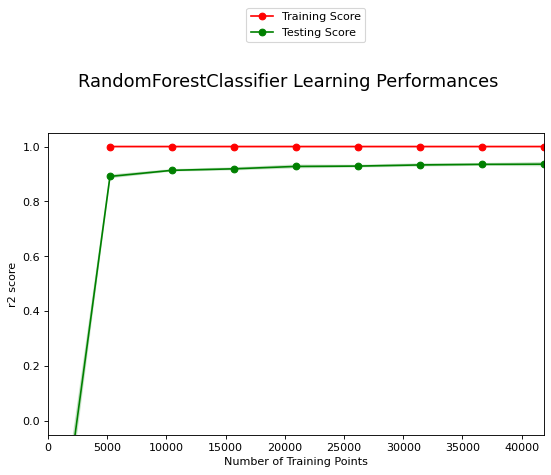

In [25]:
vc_helper.plot_learning_performance(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y)

#### RF on Word Level TF IDF Vectors
- No trace of overfitting or underfitting is observed
- Few points are needed for the model to adjust to the behavior of the dataset

##### Final observations
- RandomSearch or GridSearch could be used to find the best classif hyperparameters, but since I'm focussing on learning different architectures I will pospose this because we already get some pretty nice metrics. With this task a config file should be made.

- Cross Validation on Naive Bayes traning is missing. This, in order to estimate better how accurately the predictive model will perform in practice.